In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import math
import sys
import os
sys.path.append('../src') 

from utils.data_loader import load_data

In [2]:

df = pd.read_csv("../data/raw/portfolio_data_2015_2025.csv", header=[0, 1])
print(df.head())


       Ticker       TSLA                                                \
        Price       Open       High        Low      Close       Volume   
0        Date        NaN        NaN        NaN        NaN          NaN   
1  2015-07-01  18.073999  18.174667  17.856667  17.943333   31518000.0   
2  2015-07-02  18.680000  18.830000  18.220667  18.667999  107458500.0   
3  2015-07-06  18.591999  18.779333  18.420000  18.648001   61828500.0   
4  2015-07-07  18.333332  18.346666  17.384666  17.858667   91576500.0   

         BND                                                     SPY  \
        Open       High        Low      Close     Volume        Open   
0        NaN        NaN        NaN        NaN        NaN         NaN   
1  60.794183  60.914460  60.764112  60.816734  5399300.0  175.110995   
2  60.937024  61.027236  60.937024  60.967094  1060100.0  175.397596   
3  61.222695  61.222695  61.057308  61.177586  2210700.0  173.458760   
4  61.410611  61.470746  61.237705  61.237705  41

In [5]:
df.isna().sum()
df.dropna()


Ticker        TSLA                                                   \
           Price        Open        High         Low       Close       Volume   
1     2015-07-01   18.073999   18.174667   17.856667   17.943333   31518000.0   
2     2015-07-02   18.680000   18.830000   18.220667   18.667999  107458500.0   
3     2015-07-06   18.591999   18.779333   18.420000   18.648001   61828500.0   
4     2015-07-07   18.333332   18.346666   17.384666   17.858667   91576500.0   
5     2015-07-08   17.288000   17.386667   16.954000   16.997334   93316500.0   
...          ...         ...         ...         ...         ...          ...   
2531  2025-07-24  310.000000  310.149994  300.410004  305.299988  156966000.0   
2532  2025-07-25  308.739990  323.630005  308.010010  316.059998  148227000.0   
2533  2025-07-28  318.450012  330.489990  315.690002  325.589996  112673800.0   
2534  2025-07-29  325.549988  326.250000  318.250000  321.200012   87358900.0   
2535  2025-07-30  322.179993  324.450012  311.619995  319.040009   83931900.0   

            BND                                                     SPY  \
           Open       High        Low      Close     Volume        Open   
1     60.794183  60.914460  60.764112  60.816734  5399300.0  175.110995   
2     60.937024  61.027236  60.937024  60.967094  1060100.0  175.397596   
3     61.222695  61.222695  61.057308  61.177586  2210700.0  173.458760   
4     61.410611  61.470746  61.237705  61.237705  4183200.0  174.461933   
5     61.373039  61.463252  61.312898  61.410629  1967800.0  174.006672   
...         ...        ...        ...        ...        ...         ...   
2531  72.599185  72.798528  72.579254  72.698860  6139200.0  634.599976   
2532  72.708822  72.878265  72.688891  72.878265  4845900.0  635.090027   
2533  72.778590  72.808497  72.718791  72.758659  5806600.0  637.479980   
2534  72.838394  73.147367  72.838394  73.137398  7397900.0  638.349976   
2535  72.948036  73.107503  72.888229  72.948036  5554600.0  635.919983   

                                                       
            High         Low       Close       Volume  
1     175.363889  174.124717  174.917114  135979900.0  
2     175.566188  174.335441  174.756927  104373700.0  
3     175.043542  173.256441  174.259583  117975400.0  
4     175.481925  172.059452  175.355484  173820200.0  
5     174.293280  172.177420  172.413452  164020100.0  
...          ...         ...         ...          ...  
2531  636.150024  633.989990  634.419983   71307100.0  
2532  637.580017  634.840027  637.099976   56865400.0  
2533  638.039978  635.539978  636.940002   54917100.0  
2534  638.669983  634.340027  635.260010   60556300.0  
2535  637.679993  631.539978  634.460022   80418900.0  

[2535 rows x 16 columns]

In [7]:

# Load the data
tsla_data = df['TSLA'][['Close']].copy()
tsla_data.columns = ['Close']
tsla_data

,Close
0,NaN
1,17.943333
2,18.667999
3,18.648001
4,17.858667
...,...
2531,305.299988
2532,316.059998
2533,325.589996
2534,321.200012


In [11]:
tsla_data.dropna()

,Close
1,17.943333
2,18.667999
3,18.648001
4,17.858667
5,16.997334
...,...
2531,305.299988
2532,316.059998
2533,325.589996
2534,321.200012


In [29]:
print(tsla_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2536 entries, 0 to 2535
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2535 non-null   float64
dtypes: float64(1)
memory usage: 19.9 KB
None


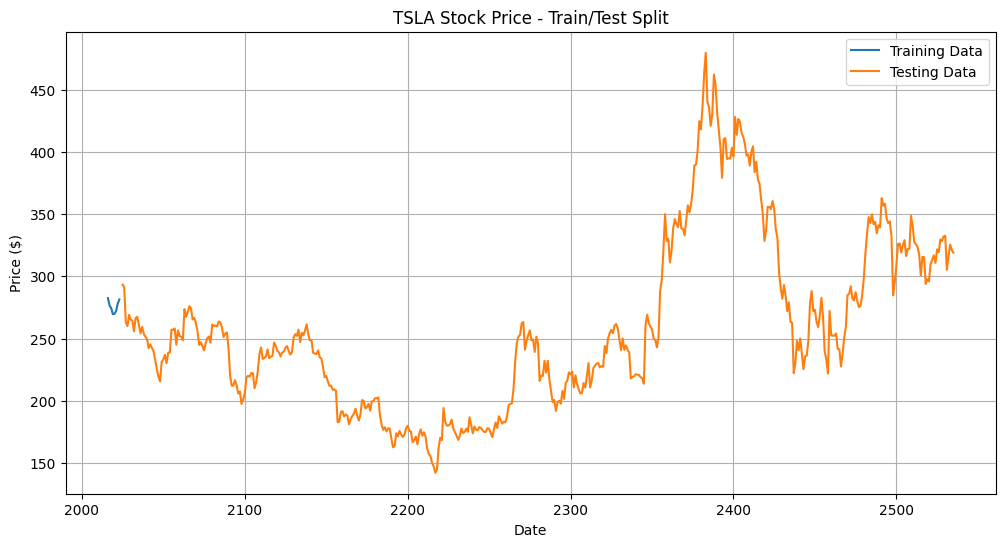

In [12]:
# Chronological split (train: 2015-2023, test: 2024-2025)
train = tsla_data.loc['2015-07-01':'2023-12-31']
test = tsla_data.loc['2024-01-01':]

# Plot the split
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Close'], label='Training Data')
plt.plot(test.index, test['Close'], label='Testing Data')
plt.title('TSLA Stock Price - Train/Test Split')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
print(train['Close'].dtype)
print(train['Close'].isna().sum())
print(train.columns)

float64
0
Index(['Close'], dtype='object')


Data date range:
Start: 2016
End: 2023
Number of observations: 8

Using 3 lags for ACF/PACF analysis


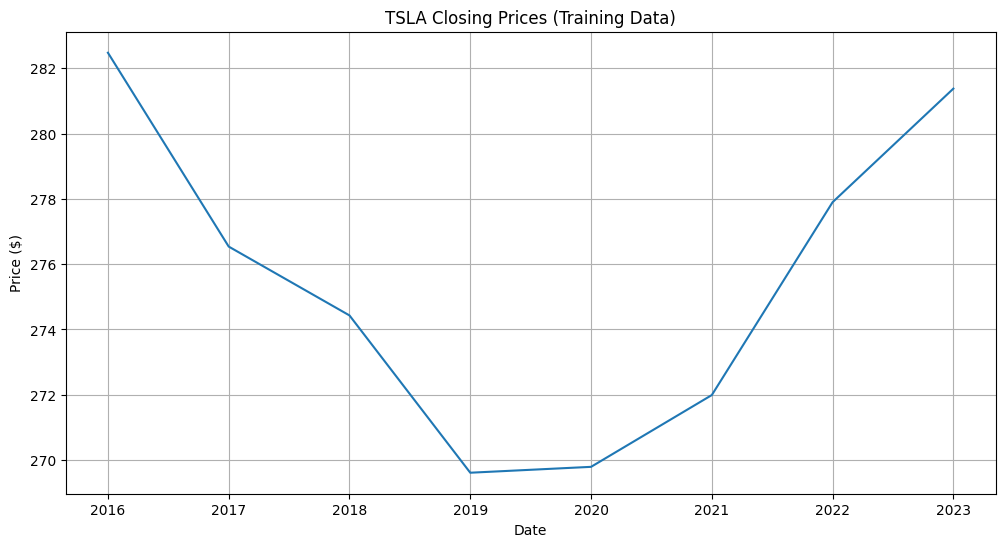

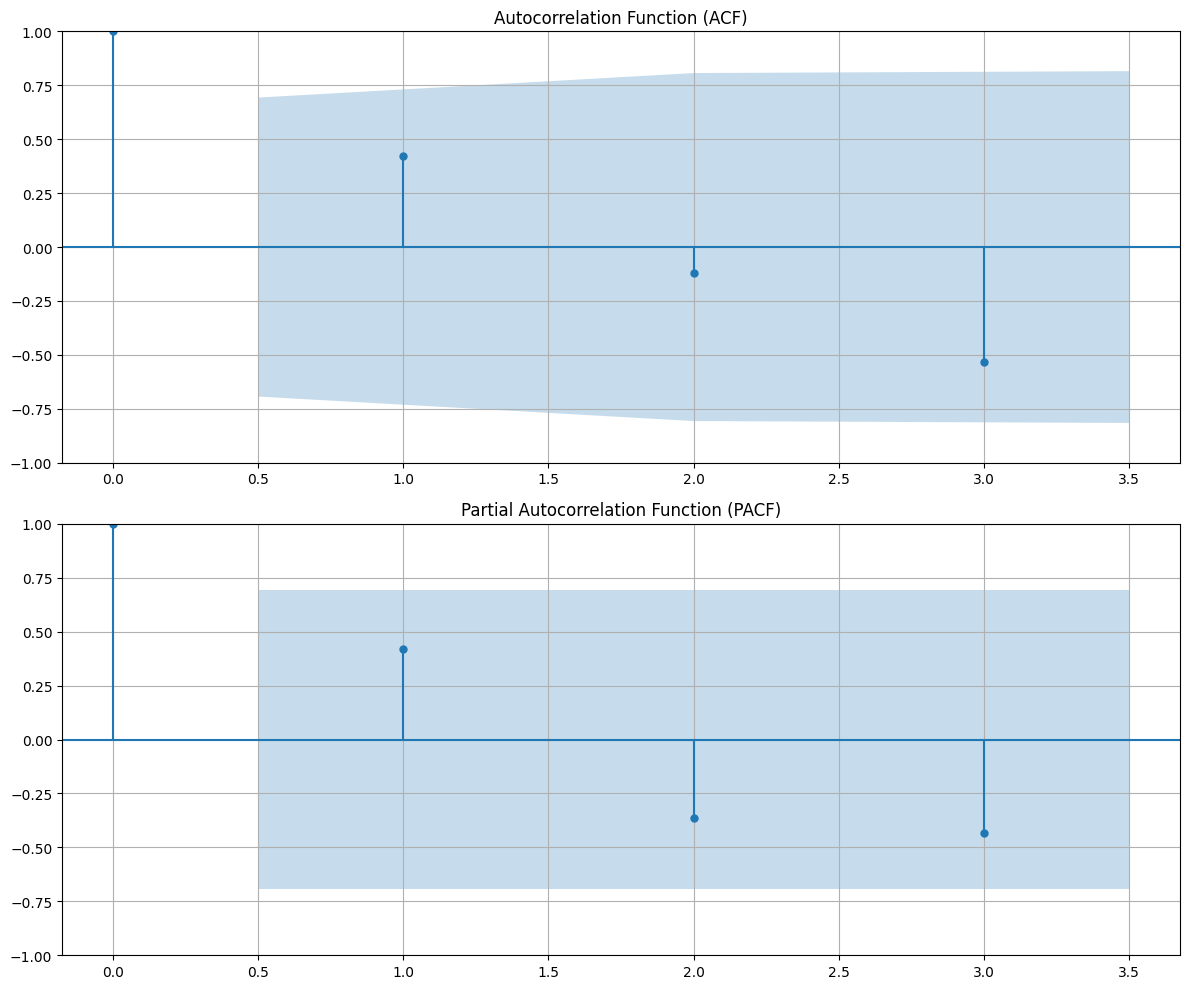


Augmented Dickey-Fuller Test Results:
ADF Statistic: -7.165460467417023
p-value: 2.8942467506305216e-10
Critical Values:
   1%: -6.045114
   5%: -3.9292800000000003
   10%: -2.98681

Data appears stationary - no differencing needed
Suggested ARIMA orders based on plots:
Look for where PACF cuts off (p) and ACF cuts off (q)
Differencing order (d) = 0


In [18]:
from statsmodels.tsa.stattools import adfuller

# First, let's verify our data
print("Data date range:")
print(f"Start: {train.index.min()}")
print(f"End: {train.index.max()}")
print(f"Number of observations: {len(train)}")

# Adjust our analysis based on available data
max_lags = min(40, len(train) // 2 - 1)  # Use at most half the data length for lags
print(f"\nUsing {max_lags} lags for ACF/PACF analysis")

# Plot the closing prices to visualize
plt.figure(figsize=(12, 6))
plt.plot(train['Close'])
plt.title('TSLA Closing Prices (Training Data)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.show()

# Plot ACF and PACF with adjusted lags
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# ACF plot
plot_acf(train['Close'], lags=max_lags, ax=ax1, title='Autocorrelation Function (ACF)')
ax1.grid(True)

# PACF plot
plot_pacf(train['Close'], lags=max_lags, ax=ax2, title='Partial Autocorrelation Function (PACF)')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Check stationarity with Augmented Dickey-Fuller test
adf_result = adfuller(train['Close'])
print("\nAugmented Dickey-Fuller Test Results:")
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value}")

# If not stationary (p-value > 0.05), difference the data
if adf_result[1] > 0.05:
    print("\nData is not stationary - applying differencing")
    differenced = train['Close'].diff().dropna()
    
    # Plot differenced series
    plt.figure(figsize=(12, 6))
    plt.plot(differenced)
    plt.title('Differenced Series')
    plt.grid(True)
    plt.show()
    
    # ADF test on differenced data
    adf_diff = adfuller(differenced)
    print("\nADF Test on Differenced Data:")
    print(f"ADF Statistic: {adf_diff[0]}")
    print(f"p-value: {adf_diff[1]}")
    
    # Plot ACF/PACF of differenced data
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    plot_acf(differenced, lags=max_lags, ax=ax1, title='ACF of Differenced Series')
    plot_pacf(differenced, lags=max_lags, ax=ax2, title='PACF of Differenced Series')
    plt.tight_layout()
    plt.show()
    
    # Determine ARIMA orders from differenced series plots
    print("\nSuggested ARIMA orders based on plots:")
    print("Look for where PACF cuts off (p) and ACF cuts off (q)")
    print("Differencing order (d) = 1")
else:
    print("\nData appears stationary - no differencing needed")
    print("Suggested ARIMA orders based on plots:")
    print("Look for where PACF cuts off (p) and ACF cuts off (q)")
    print("Differencing order (d) = 0")

d:\projects\TenAcademy\week11\KAIM-WEEK-11\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\projects\TenAcademy\week11\KAIM-WEEK-11\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                    8
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 -17.072
Date:                Tue, 12 Aug 2025   AIC                             44.144
Time:                        16:13:41   BIC                             44.541
Sample:                             0   HQIC                            41.465
                                  - 8                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        276.3119      1.933    142.922      0.000     272.523     280.101
ar.L1          1.4868      0.302      4.927      0.000       0.895       2.078
ar.L2         -0.9555      0.114     -8.378      0.0

d:\projects\TenAcademy\week11\KAIM-WEEK-11\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<Figure size 1200x600 with 0 Axes>

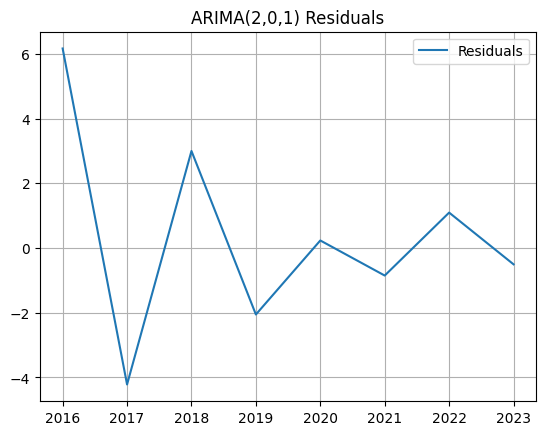

<Figure size 1200x600 with 0 Axes>

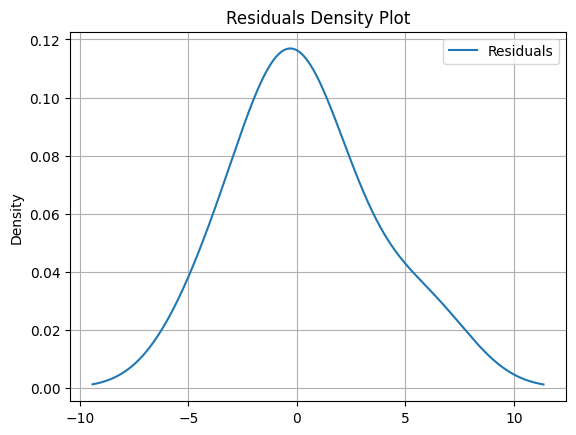

<Figure size 800x800 with 0 Axes>

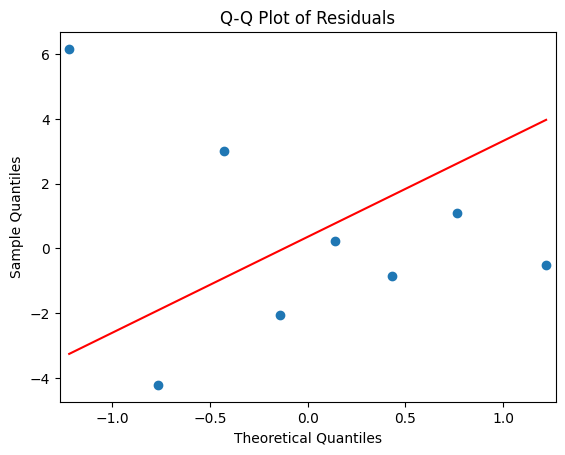


Performing Ljung-Box test with 1 lags

Ljung-Box Test for Residual Autocorrelation:
    lb_stat  lb_pvalue
1  4.924602   0.026477


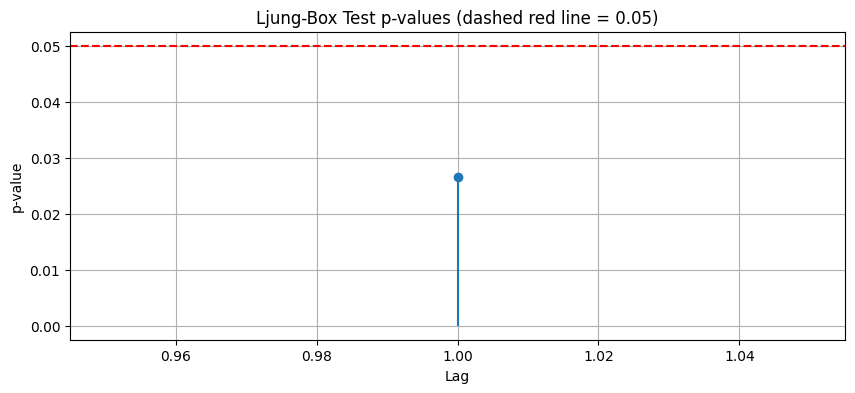

In [22]:
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox

# Fit ARIMA(2,0,1) model
arima_order = (2, 0, 1)
arima_model = ARIMA(train['Close'], order=arima_order)
arima_fit = arima_model.fit()

print(arima_fit.summary())

# Check residuals
residuals = pd.DataFrame(arima_fit.resid)
residuals.columns = ['Residuals']

# Plot residuals
plt.figure(figsize=(12, 6))
residuals.plot(title='ARIMA(2,0,1) Residuals')
plt.grid(True)
plt.show()

# Residuals diagnostics
plt.figure(figsize=(12, 6))
residuals.plot(kind='kde', title='Residuals Density Plot')
plt.grid(True)
plt.show()

# Q-Q plot of residuals
plt.figure(figsize=(8, 8))
qqplot(residuals.dropna(), line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

# Corrected Ljung-Box test
# Calculate appropriate maximum lag (rule of thumb: min(10, n/5))
max_lag = min(10, len(residuals)//5)
print(f"\nPerforming Ljung-Box test with {max_lag} lags")

if max_lag > 0:
    lb_test = acorr_ljungbox(residuals.dropna(), lags=range(1, max_lag+1), return_df=True)
    print("\nLjung-Box Test for Residual Autocorrelation:")
    print(lb_test)
    
    # Plot p-values
    plt.figure(figsize=(10, 4))
    plt.stem(lb_test.index, lb_test['lb_pvalue'])
    plt.axhline(y=0.05, color='r', linestyle='--')
    plt.title('Ljung-Box Test p-values (dashed red line = 0.05)')
    plt.xlabel('Lag')
    plt.ylabel('p-value')
    plt.grid(True)
    plt.show()
else:
    print("Not enough data for meaningful Ljung-Box test")

Forecasting with ARIMA(2,0,1)

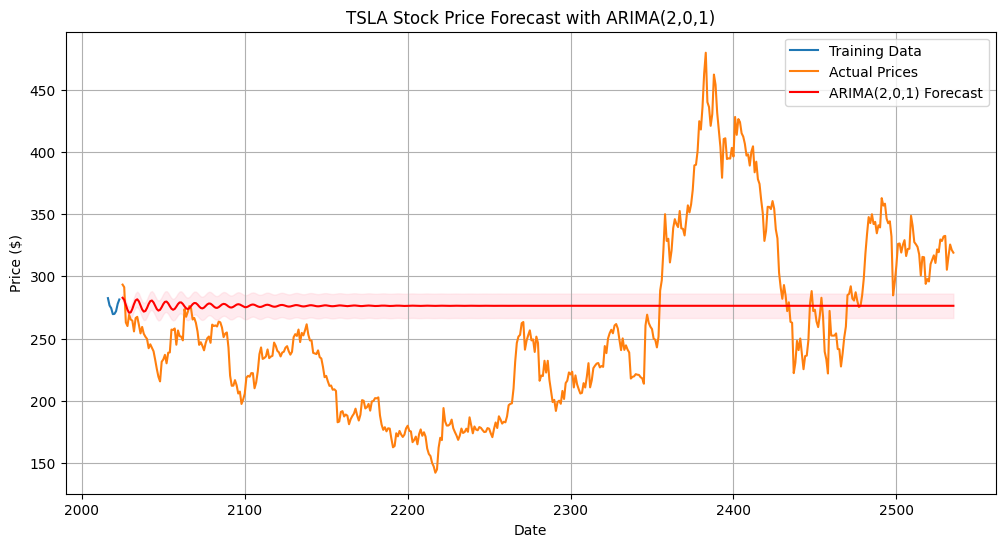


ARIMA(2,0,1) Model Evaluation:
MAE: 59.77
RMSE: 70.92
MAPE: 25.36%


In [23]:
# Forecast on test set
forecast = arima_fit.get_forecast(steps=len(test))
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Close'], label='Training Data')
plt.plot(test.index, test['Close'], label='Actual Prices')
plt.plot(test.index, forecast_values, label='ARIMA(2,0,1) Forecast', color='red')
plt.fill_between(test.index,
                confidence_intervals.iloc[:, 0],
                confidence_intervals.iloc[:, 1],
                color='pink', alpha=0.3)
plt.title('TSLA Stock Price Forecast with ARIMA(2,0,1)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

# Calculate evaluation metrics
arima_mae = mean_absolute_error(test['Close'], forecast_values)
arima_rmse = math.sqrt(mean_squared_error(test['Close'], forecast_values))
arima_mape = np.mean(np.abs((test['Close'] - forecast_values) / test['Close'])) * 100

print("\nARIMA(2,0,1) Model Evaluation:")
print(f"MAE: {arima_mae:.2f}")
print(f"RMSE: {arima_rmse:.2f}")
print(f"MAPE: {arima_mape:.2f}%")

LSTM Model Implementation (Comparison)

 Data Preprocessing for LSTM

In [28]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train[['Close']])
scaled_test = scaler.transform(test[['Close']])
# Re-examining the data shapes first
print(f"Training data shape: {scaled_train.shape}")
print(f"Test data shape: {scaled_test.shape}")

# Modified create_sequences function with validation
def create_sequences(data, seq_length):
    X, y = [], []
    available_length = len(data) - seq_length
    if available_length <= 0:
        raise ValueError(f"Not enough data for sequence length {seq_length}. Need at least {seq_length+1} samples, but only have {len(data)}")
    
    for i in range(available_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Adjust sequence length if needed
seq_length = 30
required_min_length = seq_length + 1  # Need seq_length+1 points to make one sequence

if len(scaled_train) < required_min_length:
    print(f"Warning: Not enough training data ({len(scaled_train)} points) for seq_length={seq_length}")
    seq_length = min(seq_length, len(scaled_train)-1)
    print(f"Reducing sequence length to {seq_length}")

# Create sequences with the adjusted length
try:
    X_train, y_train = create_sequences(scaled_train, seq_length)
    X_test, y_test = create_sequences(scaled_test, seq_length)
    
    print(f"\nShapes after sequence creation:")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
    
    # Reshape only if necessary (should already be 3D)
    if len(X_train.shape) == 2:
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    print(f"\nFinal shapes:")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

except ValueError as e:
    print(f"Error: {e}")
    print("Cannot proceed with LSTM - not enough training data")

Training data shape: (8, 1)
Test data shape: (511, 1)
Reducing sequence length to 7

Shapes after sequence creation:
X_train: (1, 7, 1), y_train: (1, 1)
X_test: (504, 7, 1), y_test: (504, 1)

Final shapes:
X_train: (1, 7, 1), y_train: (1, 1)
X_test: (504, 7, 1), y_test: (504, 1)


Build LSTM Model

In [ ]:
# Build LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train with early stopping
history = lstm_model.fit(X_train, y_train,
                        epochs=100,
                        batch_size=32,
                        validation_data=(X_test, y_test),
                        callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
                        verbose=1)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

IndexError: tuple index out of range